# Mini-project



## General guidelines

We want to make a typical study of a ML problem.

We're going to use Fashion-MNIST ("*fashion-mnist-reshaped.npz*")  as data set, attempting to classify the pictures correctly.

There are 2 parts in the project:
- use `DecisionTreeClassifier` and PCA from sklearn to classify the data
- make your own multi-class classifier, deriving its updates from scratch
The first part weights more in the total grade than the second one.

In the first part, the goal is to showcase a typical hyper-parameter tuning. We will simulate the fact of having different tasks by restricting ourselves to different dataset size, and comment on how hyper-parameters choice can depend a lot on how much data we have at hand.

General advice: **write clean code**, well factored in functions/classes, for each question, as much as possible.
This will make your code **easier to read and also easier to run!**. You may re-use code in several questions. If it's  well factored, it will be easier to code the next questions.

Tips: you may want to use 
- `sklearn.tree.DecisionTreeClassifier`
- `sklearn.model_selection.train_test_split`
- `sklearn.decomposition.PCA`
- `sklearn.model_selection.cross_validate` 

to lighten your code.

## Part 1: using `sklearn.tree.DecisionTreeClassifier`

## (about 15 points over 20 total)

Decision Trees are powerful methods, however they can easily overfit. The number of parameters in the model essenitially grows like $\sim O(2^{maxDepth})$, i.e. exponentially with the depth of the tree.

### Part 1.1: `Ntrain+Nval=1000, Nvalid=1000, Ntest=10000`

In this part we use this amount of data.
- import the data, split the "train+validation" sets. Keep the test set for the **very** end.
- attempt direct classification using a `sklearn.tree.DecisionTreeClassifier`. Optimize the hyper-parameter `max_depth`. Measure and store the validation accuracy for the best choice of `max_depth`.
Do you fear you may be overfitting ? Explain your answer.
- Now, let's add some PCA as pre-processing. 
    - Using `max_depth=5`, what is the best number of PCA components (nComp_PCA) to keep ? Hint: you may use something like `nComp_range = np.array(list(np.arange(1,50))+[50,100,200,400,783,784])` as the range of nComp_PCA values to be explored.
    - Using `max_depth=12`, what is the best number of PCA components (nComp_PCA) to keep ?
    - Can you explain why this optimal number changes with depth ? 
- Find the best (max_depth, nComp_PCA) pair. 
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **small** `nComp_PCA` ?
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **large** `nComp_PCA` ?
- Measure the cross-validation error for this best pair. Are you surprised with the result?

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score, cross_validate
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.decomposition import  PCA

import pandas as pd

#### Load Data

In [2]:
LoadObject = np.load("../tools+data/fashion-mnist-reshaped.npz") # please put your data over there so it's easy for me to run your code
linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
## we do not use the TEST SET for now:
# Xtest = LoadObject['test_images']
# ytest = LoadObject['test_labels']

In [12]:
seed = 42
max_depth_range = np.array(list(np.arange(1,15))+list(np.arange(16,30,3)))
nComp_range = np.array(list(np.arange(1,29,2))+[30,50,100,150,200,300,400,500,600,783,784])

### Part I

Splitting the data into train and validation set. Note that a test set is put completely aside in Fashion-MNIST dataset.

In [7]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

Selecting a subset of N examples from the train and validation sets

In [8]:
Ntrain = 1000
Nval = 1000

x1_train = x_train[0:Ntrain,:]
y1_train = y_train[0:Ntrain]

x1_val = x_val[0:Nval,:]
y1_val = y_val[0:Nval]

Note that the size of the training and validation sets is small (N=1000).

We thus use the training subset for training and hyper-parameter search and the validation set thus defined 
to estimate the generalization performance.


Although high predictive accuracy is the most frequently used measure to evaluate learning
algorithms, in many applications, easy interpretation of the induced models is also an important
requirement. Good predictive performance and model interpretability are found in one of the most
successful set of classification algorithms: Decision Tree (DT) induction algorithms.

When applied to a dataset, these algorithms induce a model represented by a set of rules in a tree-like
structure [1].

Performing a base classification using DecisionTrees:

In [17]:
clf1 = DecisionTreeClassifier(random_state=seed)
clf1 = clf1.fit(x1_train, y1_train)

clf1_tree = export_text(clf1)
#print(clf_tree)
scores = cross_val_score(clf1, x1_train, y1_train, cv=5)

print('Depth of tree in base classifier: ',clf1.get_depth())
print("CV accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Test accuracy: ', clf1.score(x1_val, y1_val))

Depth of tree in base classifier:  12
CV accuracy: 0.66 (+/- 0.06)
Test accuracy:  0.705


We see the default depth chosen to be 12 with a CV score of about 66%. In general, the deeper we allow the tree to grow, 
the more complex our model will become 
because we will have more splits and it captures more information about the data. This is one 
of the root causes of overfitting in decision trees because our model will fit perfectly for the training 
data and will not be able to generalize well on test set. So, if our model is overfitting, reducing the 
number for max_depth is one way to combat overfitting.

It is also bad to have a very low depth because the model might underfit. And since
overfitting and underfitting are very subjective to a dataset, there is no one value 
fits all solution. 

Hence our general methodology is to quantify overfitting and underfitting. This is reflected in the train and validation error.
And this is what we use as the basis to select one set of hyperparameters over another.

We use Grid Search CV with the following steps:
* Manually set a grid of discrete hyperparameter values
* Set a metric for scoring model performance
* Search exhaustively through the grid
* For each set of hyperparameters, evaluate each model's CV score
* The optimal hyperparameters are those of the model achieving the best CV score

Optimizing the hyper-parameter max_depth using Grid-Search with 5 Stratified-folds and 'Accuracy'
as the scoring metric:

In [15]:
#max_depth_range = np.arange(11,71,5)
#max_depth_range = np.array(list(np.arange(1,10))+list(np.arange(11,71,5)))
param_grid = [{'max_depth': max_depth_range }]
clf1_opt = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid,
                   scoring='accuracy', cv = 5)
clf1_opt.fit(x1_train, y1_train)

parameters = clf1_opt.cv_results_['params']
means = clf1_opt.cv_results_['mean_test_score']
stds = clf1_opt.cv_results_['std_test_score']

In [16]:
print('Grid scores: \n')
for parameter, mean, std in zip(parameters, means, stds):
    print("%0.3f (+/- %0.3f) for %r " %(mean, 2*std, parameter))

print()
print('Best hyper-parameters found: ', clf1_opt.best_params_)
print('Best CV score: ', clf1_opt.best_score_)
print('Test accuracy: ', clf1_opt.best_estimator_.score(x1_val, y1_val))

Grid scores: 

0.214 (+/- 0.010) for {'max_depth': 1} 
0.361 (+/- 0.038) for {'max_depth': 2} 
0.494 (+/- 0.054) for {'max_depth': 3} 
0.632 (+/- 0.057) for {'max_depth': 4} 
0.670 (+/- 0.052) for {'max_depth': 5} 
0.673 (+/- 0.037) for {'max_depth': 6} 
0.676 (+/- 0.043) for {'max_depth': 7} 
0.678 (+/- 0.072) for {'max_depth': 8} 
0.683 (+/- 0.061) for {'max_depth': 9} 
0.680 (+/- 0.085) for {'max_depth': 10} 
0.671 (+/- 0.079) for {'max_depth': 11} 
0.669 (+/- 0.061) for {'max_depth': 12} 
0.658 (+/- 0.069) for {'max_depth': 13} 
0.666 (+/- 0.078) for {'max_depth': 14} 
0.662 (+/- 0.064) for {'max_depth': 16} 
0.662 (+/- 0.064) for {'max_depth': 19} 
0.662 (+/- 0.064) for {'max_depth': 22} 
0.662 (+/- 0.064) for {'max_depth': 25} 
0.662 (+/- 0.064) for {'max_depth': 28} 

Best hyper-parameters found:  {'max_depth': 9}
Best CV score:  0.683
Test accuracy:  0.68


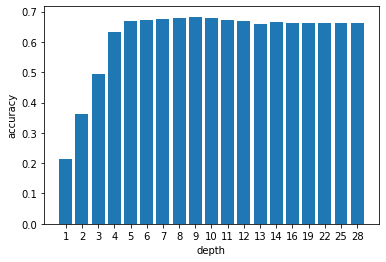

In [18]:
plt.bar(list(map(str, max_depth_range)), means, label='Test Score')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.savefig("1.1 cv_GS_bar.pdf")
plt.show()

We note that the best averaged score over all folds for each value of the depth of the tree
comes out to be about 68% with least variance for a depth of 9. This optimal depth searched is 
is less than that of the default classifier which might have been overfitting.

The following plot makes this more tangible:

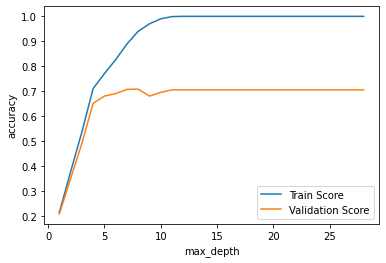

In [20]:
#to create a list of validation score for each hyperparameter value for plot
valid_score = []
train_score = []
for i in max_depth_range:
    clf1_val = DecisionTreeClassifier(max_depth=i, random_state=seed)
    clf1_val.fit(x1_train, y1_train)
    valid_score.append(clf1_val.score(x1_val,y1_val))
    train_score.append(clf1_val.score(x1_train, y1_train))
  
plt.plot(max_depth_range, train_score, label='Train Score')
plt.plot(max_depth_range, valid_score, label='Validation Score')  
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.savefig("1.1 curve.pdf")
plt.show()

Looking at the large gap between training and validation error,
we can conclude that the model is over-fitting. This was rather expected given the very small size of the 
dataset used so far.

We also observe that after a certain depth, the train and validation score flat-out marking 
the over-fitting regime.

Given the constraint of the size of the dataset, we look at dimensionality reduction for aid.
So next we search for the optimum number of Principle Components again using GridSearch.

In [21]:
def optComp(DTC_MaxDepth, compRange, max_depth_rng, x_train, y_train, depthBool): 
    if depthBool == True:
        estimators = [('pca', PCA()), ('clf', DecisionTreeClassifier(random_state=seed))]
        param_grid_PCA = {'pca__n_components': compRange, 'clf__max_depth': max_depth_rng}
    else:
        estimators = [('pca', PCA()), ('clf', DecisionTreeClassifier(max_depth=DTC_MaxDepth, random_state=seed))]
        param_grid_PCA = {'pca__n_components': compRange}
    pipe = Pipeline(steps=estimators)    
    clf_PCA = GridSearchCV(pipe, param_grid_PCA, scoring='accuracy', cv=5)
    clf_PCA.fit(x_train, y_train)
    
    parameters_PCA = clf_PCA.cv_results_['params']
    means_PCA = clf_PCA.cv_results_['mean_test_score']
    stds_PCA = clf_PCA.cv_results_['std_test_score']
    
    return clf_PCA, parameters_PCA, means_PCA, stds_PCA

In [22]:
def print_PCAscore(parameters_PCA, means_PCA, stds_PCA, clf_PCA, nComp_range, x_val, y_val):  
    print('Grid scores: \n')
    for parameter, mean, std in zip(parameters_PCA, means_PCA, stds_PCA):
        print("%0.3f (+/- %0.3f) for %r " %(mean, 2*std, parameter))
    
    print()
    print('Best hyper-parameters found: ', clf_PCA.best_params_)
    print('Best CV score: ', clf_PCA.best_score_)
    print('Test accuracy: ', clf_PCA.best_estimator_.score(x_val, y_val))

In [70]:
def learning_curves(DTC_MaxDepth, compRange, max_depth_rng, x_train, y_train, x_val, y_val, depthBool):
    valid_score = []
    train_score = []
    if depthBool == True:
        estimators = [('pca', PCA()), ('clf', DecisionTreeClassifier(random_state=seed))]
        for i in compRange:
            for j in max_depth_rng:
                pipe = Pipeline(steps=estimators) 
                pipe.set_params(pca__n_components=i, clf__max_depth=j)
                pipe.fit(x1_train, y1_train)
                if j%10==0:
                    valid_score.append(pipe.score(x_val,y_val))
                    train_score.append(pipe.score(x_train, y_train))
                
            plt.scatter(i*np.ones(len(train_score)), train_score, marker='x')     
            plt.scatter(i*np.ones(len(valid_score)), valid_score, marker='x')    
            valid_score = []
            train_score = []
        plt.legend()
        plt.xlabel('nComponents')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.xlim(0,210)
    else:
        estimators = [('pca', PCA()), ('clf', DecisionTreeClassifier(max_depth=DTC_MaxDepth, random_state=seed))]   
        for i in compRange:
            pipe = Pipeline(steps=estimators) 
            pipe.set_params(pca__n_components=i)
            pipe.fit(x1_train, y1_train)
            valid_score.append(pipe.score(x_val,y_val))
            train_score.append(pipe.score(x_train, y_train))
        
        plt.plot(compRange, train_score, label='Train Score')
        plt.plot(compRange, valid_score, label='Validation Score')    

        plt.legend()
        plt.xlabel('nComponents')
        plt.ylabel('accuracy')
        plt.savefig('1.4 bonus curve_optDepth_optPCA.pdf')
        plt.plot()
        

Plotting the number of components that explain 95% of the variance, we see that about 140 components suffice.
Indeed a trait of image data.

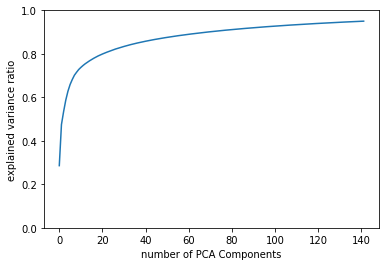

In [24]:
## displaying the total variance explained at various values of nComp
varianceExplained=0.95
preProc = PCA(n_components=varianceExplained, copy=True)
preProc.fit(x1_train)

CumulativeExplainedVariance = np.cumsum(preProc.explained_variance_ratio_)
plt.plot(CumulativeExplainedVariance)
plt.xlabel("number of PCA Components")
plt.ylabel("explained variance ratio")
plt.ylim([0,1])
plt.savefig("1.1 PCA varianceExplained.pdf")
plt.show()

We first look for the optimum number of principle components for a max_depth of 5:

In [15]:
#define the number of principle components to be tested
#nComp_range = np.array(list(np.arange(1,50))+[50,100,150,200,300,400,500,600,783,784])

#### max_depth = 5, search nComp

In [25]:
clf_PCA1, parameters_PCA1, means_PCA1, stds_PCA1 = optComp(5, nComp_range, max_depth_range, x1_train, y1_train, depthBool=False)
print_PCAscore(parameters_PCA1, means_PCA1, stds_PCA1, clf_PCA1, nComp_range, x1_val, y1_val)

Grid scores: 

0.284 (+/- 0.013) for {'pca__n_components': 1} 
0.532 (+/- 0.053) for {'pca__n_components': 3} 
0.565 (+/- 0.053) for {'pca__n_components': 5} 
0.584 (+/- 0.062) for {'pca__n_components': 7} 
0.598 (+/- 0.063) for {'pca__n_components': 9} 
0.595 (+/- 0.077) for {'pca__n_components': 11} 
0.594 (+/- 0.075) for {'pca__n_components': 13} 
0.587 (+/- 0.073) for {'pca__n_components': 15} 
0.590 (+/- 0.083) for {'pca__n_components': 17} 
0.593 (+/- 0.067) for {'pca__n_components': 19} 
0.592 (+/- 0.086) for {'pca__n_components': 21} 
0.595 (+/- 0.078) for {'pca__n_components': 23} 
0.590 (+/- 0.076) for {'pca__n_components': 25} 
0.592 (+/- 0.085) for {'pca__n_components': 27} 
0.590 (+/- 0.081) for {'pca__n_components': 30} 
0.592 (+/- 0.070) for {'pca__n_components': 50} 
0.591 (+/- 0.068) for {'pca__n_components': 100} 
0.585 (+/- 0.082) for {'pca__n_components': 150} 
0.591 (+/- 0.070) for {'pca__n_components': 200} 
0.581 (+/- 0.069) for {'pca__n_components': 300} 
0.575 

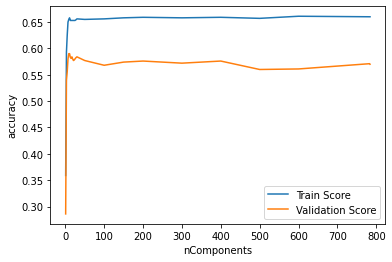

In [29]:
learning_curves(5, nComp_range, max_depth_range, x1_train, y1_train, x1_val, y1_val, depthBool=False)

We recall that we observed upto 67% accuracy with a depth of 5 previously without PCA. Here we observe
a score of 53.7% for all 784 components. The discrepancy must be attributed to the rotation about the 
principle axes. Thus the score is lower on average than without using PCA at all.

But we observe that the train score is much lower with PCA. Hence we're moving to the regime of underfitting
from overfitting, i.e. an increase in model power should surely improve the results.

For the max_depth of 5, the validation score of about 60.2% is observed for 9 principle components.

Now we try finding the optimum number of principle components for a max_depth of 12:

In [31]:
clf_PCA1, parameters_PCA1, means_PCA1, stds_PCA1 = optComp(12, nComp_range, max_depth_range, x1_train, y1_train, depthBool=False)
print_PCAscore(parameters_PCA1, means_PCA1, stds_PCA1, clf_PCA1, nComp_range, x1_val, y1_val)

Grid scores: 

0.217 (+/- 0.041) for {'pca__n_components': 1} 
0.576 (+/- 0.062) for {'pca__n_components': 3} 
0.630 (+/- 0.030) for {'pca__n_components': 5} 
0.636 (+/- 0.070) for {'pca__n_components': 7} 
0.649 (+/- 0.057) for {'pca__n_components': 9} 
0.656 (+/- 0.069) for {'pca__n_components': 11} 
0.651 (+/- 0.058) for {'pca__n_components': 13} 
0.657 (+/- 0.074) for {'pca__n_components': 15} 
0.669 (+/- 0.083) for {'pca__n_components': 17} 
0.648 (+/- 0.071) for {'pca__n_components': 19} 
0.648 (+/- 0.089) for {'pca__n_components': 21} 
0.647 (+/- 0.066) for {'pca__n_components': 23} 
0.644 (+/- 0.050) for {'pca__n_components': 25} 
0.650 (+/- 0.097) for {'pca__n_components': 27} 
0.638 (+/- 0.081) for {'pca__n_components': 30} 
0.642 (+/- 0.083) for {'pca__n_components': 50} 
0.625 (+/- 0.089) for {'pca__n_components': 100} 
0.623 (+/- 0.086) for {'pca__n_components': 150} 
0.621 (+/- 0.047) for {'pca__n_components': 200} 
0.619 (+/- 0.042) for {'pca__n_components': 300} 
0.591 

#### max_depth = 12, search nComp

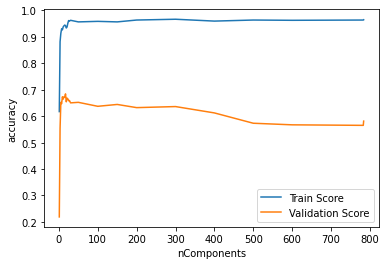

In [32]:
learning_curves(12, nComp_range, max_depth_range, x1_train, y1_train, x1_val, y1_val, depthBool=False)

Hence we see that 17 principle components are best for a max_depth of 12 giving an improved validation accuracy
of 66.9% and test score of about 67% as expected. Thus we're not far from out original score without PCA, only now we have only 30 features instead of 784.

The increase in model complexity lends itself to the increase in generalization score now and we also 
see the increase in training accuracy with a large gap in test and train accuracy, denoting increasing
overfitting which is expected with a more complex model.

Next finding the optimum number of principle components and max_depth:

#### search max_depth, nComp

In [45]:
clf_PCA1, parameters_PCA1, means_PCA1, stds_PCA1 = optComp(1, x_train=x1_train, y_train=y1_train, compRange=nComp_range, max_depth_rng=max_depth_range, depthBool=True)
print_PCAscore(parameters_PCA1, means_PCA1, stds_PCA1, clf_PCA1, nComp_range, x1_val, y1_val)

Grid scores: 

0.201 (+/- 0.021) for {'clf__max_depth': 1, 'pca__n_components': 1} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 3} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 5} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 7} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 9} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 11} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 13} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 15} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 17} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 19} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 21} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 23} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 25} 
0.222 (+/- 0.019) for {'clf__max_depth': 1, 'pca__n_components': 27} 
0.222 (+/-

We see a CV score of 67% and test score of 65% for the optimal
max_depth of 14 and 17 principle components as searched. But note the score is not any different than the last result
and using Occam's razor, it is sensible to consider 12 max depth with 17 components.

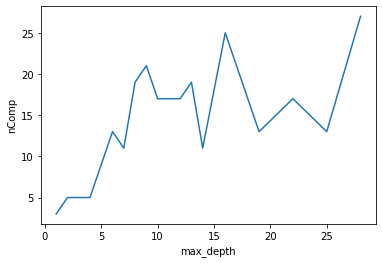

In [36]:
df_depth = [d['clf__max_depth'] for d in parameters_PCA1]
df_nComp = [d['pca__n_components'] for d in parameters_PCA1]
df_score = means_PCA1
df = pd.DataFrame(list(zip(df_depth, df_nComp, df_score)), columns =['max_depth', 'nComp', 'score'])
df2 = df.loc[df.groupby(["max_depth"])["score"].idxmax()]
sns.lineplot(x=df2.max_depth, y=df2.nComp)
plt.savefig("1.1 depthVSnComp.pdf")
plt.show()

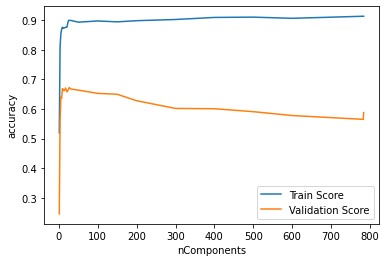

In [40]:
learning_curves(10, nComp_range, max_depth_range, x1_train, y1_train, x1_val, y1_val, depthBool=False)

In [23]:
#learning_curves(1, nComp_range, max_depth_range, depthBool=True)

### Part 1.2: `Ntrain+Nval=2000, Nvalid=2000`

If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets. 
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?

Selecting a subset of N examples from the train and validation sets

In [43]:
Ntrain = 2000
Nval = 2000

x2_train = x_train[0:Ntrain,:]
y2_train = y_train[0:Ntrain]

x2_val = x_val[0:Nval,:]
y2_val = y_val[0:Nval]

With an increase in the number of examples to double the first case, we can now study the change in the optimal hyper-parameters
for the model.

#### search  max_depth, nComp for N = 2000

In [44]:
clf_PCA2, parameters_PCA2, means_PCA2, stds_PCA2 = optComp(1, x_train=x2_train, y_train=y2_train, compRange=nComp_range, max_depth_rng=max_depth_range, depthBool=True)
print_PCAscore(parameters_PCA2, means_PCA2, stds_PCA2, clf_PCA2, nComp_range, x2_val, y2_val)

Grid scores: 

0.186 (+/- 0.014) for {'clf__max_depth': 1, 'pca__n_components': 1} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 3} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 5} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 7} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 9} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 11} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 13} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 15} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 17} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 19} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 21} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 23} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 25} 
0.202 (+/- 0.007) for {'clf__max_depth': 1, 'pca__n_components': 27} 
0.202 (+/-

We thus find an improved validation score of 67.6% with an optimal max depth of 11 and 50 principle components for this dataset
with higher number of training examples. 

We see these max_depth to have increased as expected
since we have more data than in the previous case
with less examples (max depth = 10, principle components= 25).

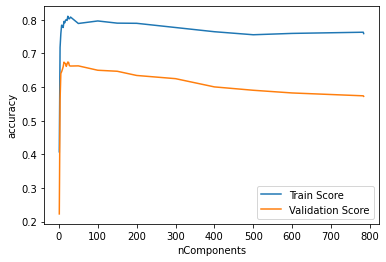

In [46]:
learning_curves(11, nComp_range, max_depth_range, x2_train, y2_train, x2_val, y2_val, depthBool=False)

Also the gap between the training and validation score curve is smaller with the increase in dataset.
We should expect this trend to continue with a larger dataset.
### Part 1.3: `Ntrain+Nval=20000, Nvalid=10000`
If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets.
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?

**Hint: to save compute time, you can use a smaller hyper-parameter search space, i.e. you can reduce the umber of values explored in your hyper-optimization.**

In [49]:
Ntrain = 20000
Nval = 10000

x3_train = x_train[0:Ntrain,:]
y3_train = y_train[0:Ntrain]

x3_val = x_val[0:Nval,:]
y3_val = y_val[0:Nval]

max_depth_range3 = np.array(list(np.arange(1,18,4)))
nComp_range3 = np.array(list(np.arange(1,26,5))+[30,50,100,200,400,600,784])

Now we have a good number of examples. We expect the optimal params to further decrease with an increase in score.
Note that we have reduces the search space to ease the computation time.

In [28]:
#max_depth_range = np.array(list(np.arange(1,11))+list(np.arange(10,21,2)))
#nComp_range = np.array(list(np.arange(1,26,2))+[30,50,100,150,200,300,400,500,600,783,784])

#### search  max_depth, nComp for N = 20,000

In [52]:
clf_PCA3, parameters_PCA3, means_PCA3, stds_PCA3 = optComp(1, x_train=x3_train, y_train=y3_train, compRange=nComp_range3, max_depth_rng=max_depth_range3, depthBool=True)
print_PCAscore(parameters_PCA3, means_PCA3, stds_PCA3, clf_PCA3, nComp_range3, x3_val, y3_val)

Grid scores: 

0.191 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 1} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 6} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 11} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 16} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 21} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 30} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 50} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 100} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 200} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 400} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 600} 
0.195 (+/- 0.002) for {'clf__max_depth': 1, 'pca__n_components': 784} 
0.314 (+/- 0.009) for {'clf__max_depth': 5, 'pca__n_components': 1} 
0.604 (+/- 0.013) for {'clf__max_depth': 5, 'pca__n_components': 6} 
0.61

We thus find an improved validation score of 75.3% with an optimal max depth of 13 and 30 principle components for this dataset
with higher number of training examples. 

We see these optimal numbers to have changed than in the previous case
with less examples (max depth = 14, principle components= 17).

We finally see that the model is not over-fitting anymore.

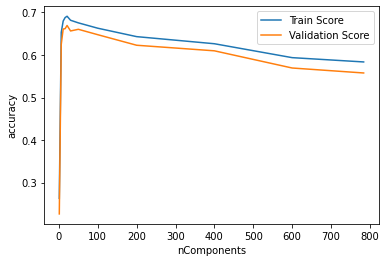

In [54]:
learning_curves(13, nComp_range3, max_depth_range3, x3_train, y3_train, x3_val, y3_val, depthBool=False)

### Part 1.4: The test (with `Ntest=10000`)
Use your best model to make a prediction:
- Which model do you prefer, among the 3 "best models" you have found? 
  Why? How confident are you with your choice?
- Using your `Ntest=10000` samples that you saved preciously (and NEVER used), 
  compute the test error. How surprised are you with the result? 
- If you were asked by a client, "what is the level of accuracy you can achieve", 
  what would be your answer ?


In [55]:
Xtest = LoadObject['test_images']
Ytest = LoadObject['test_labels']

Ntest = 10000

x_test = Xtest[0:Ntest,:]
y_test = Ytest[0:Ntest]

We prefer the model with the best test score and least over-fitting.

In [65]:
print("Finally, the test accuracy for model with tuned hyperparamers and\n")
print('trained on N=1000: ', clf_PCA1.best_estimator_.score(x_test, y_test))
print()
print('trained on N=2000: ', clf_PCA2.best_estimator_.score(x_test, y_test))
print()
print('trained on N=20000: ', clf_PCA3.best_estimator_.score(x_test, y_test))
print()

Finally, the test accuracy for model with tuned hyperparamers and

trained on N=1000:  0.6601

trained on N=2000:  0.6717

trained on N=20000:  0.7539



In [67]:
print("We therefore select the 3rd classifier since it gives the best test accuracy")
print()
#classification report
y1_true, y1_pred = Ytest, clf_PCA3.predict(Xtest)
print(classification_report(y1_true, y1_pred))

We therefore select the 3rd classifier since it gives the best test accuracy

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1000
           1       0.90      0.91      0.91      1000
           2       0.66      0.65      0.65      1000
           3       0.79      0.73      0.76      1000
           4       0.58      0.69      0.63      1000
           5       0.85      0.82      0.84      1000
           6       0.48      0.43      0.46      1000
           7       0.84      0.86      0.85      1000
           8       0.88      0.86      0.87      1000
           9       0.88      0.89      0.89      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



The results over the test set look similar to the validation and CV score from the 
previous run.

The client must realize that the level of accuracy that can be achieved with
Decision Trees on this dataset is about 75%.

### Part 1.4 - Bonus question : 
- Compute also the cross validation error for the best hyper parameters choice with `N_train=200`
- Plot the cross validation error as a function of ntrain= 200,2000,20000  
- People often say "let's just get more data". How efficient does that does seem to be ? 

In [85]:
Ntrain = 200
Nval = 2000

x4_train = x_train[0:Ntrain,:]
y4_train = y_train[0:Ntrain]

x4_val = x_val[0:Nval,:]
y4_val = y_val[0:Nval]

nComp_range4 = np.array(list(np.arange(1,26,2))+[30,50,100,150])

In [86]:
clf_PCA4, parameters_PCA4, means_PCA4, stds_PCA4 = optComp(1, nComp_range4, max_depth_range, x4_train, y4_train, depthBool=True)
print_PCAscore(parameters_PCA4, means_PCA4, stds_PCA4, clf_PCA4, nComp_range4, x4_val, y4_val)

Grid scores: 

0.225 (+/- 0.032) for {'clf__max_depth': 1, 'pca__n_components': 1} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 3} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 5} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 7} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 9} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 11} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 13} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 15} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 17} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 19} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 21} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 23} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 25} 
0.230 (+/- 0.066) for {'clf__max_depth': 1, 'pca__n_components': 30} 
0.230 (+/-

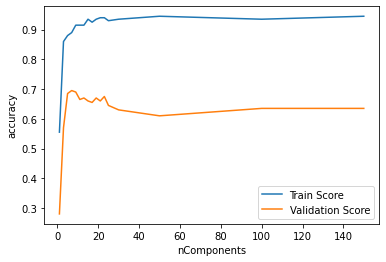

In [35]:
learning_curves(10, nComp_range4, max_depth_range, x4_train, y4_train, x4_val, y4_val, depthBool=False)

In [71]:
y4_true, y4_pred = Ytest, clf_PCA4.predict(Xtest)
print(classification_report(y4_true, y4_pred))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57      1000
           1       0.79      0.76      0.77      1000
           2       0.41      0.55      0.47      1000
           3       0.52      0.49      0.50      1000
           4       0.42      0.34      0.38      1000
           5       0.71      0.54      0.61      1000
           6       0.26      0.17      0.21      1000
           7       0.67      0.52      0.59      1000
           8       0.73      0.71      0.72      1000
           9       0.58      0.91      0.71      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000



Although the results are not bad compared to our previous models, we see the discrepancy in precision
and recall which was not the case with the previous models.

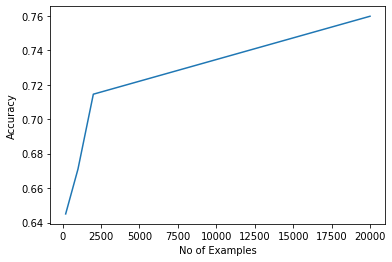

In [73]:
CV = [clf_PCA4.best_score_, clf_PCA1.best_score_, clf_PCA2.best_score_, clf_PCA3.best_score_]
Ndata = [200, 1000, 2000, 20000]

plt.plot(Ndata, CV)
plt.xlabel('No of Examples')
plt.ylabel('Accuracy')
plt.savefig("1.4 BONUS NvsScore.pdf")
plt.show()

From the plot we see that the CV score to increase with the number of training examples 
and thus an increase in generalization score. But given fact that
the increase of about 10% going from 200 to 20000 examples, depending on the cost of gathering
data and initial goals of the project, it might not be worth it.
But note that although it seems that we can get off with N=200, looking at the discrepancy between
precision and recall, atleast N=1000 should be considered base.

## Part 2: make your own classifier !

## (about 5 points over 20 total)

The multi-class percpetron can be implemented this way. 
We denote $K$ the number of classes, $N$ the number of (training) examples, $D$ the dimension of the data (after feature augmentation, at least with a "1" as first component).

The **output** of the network *(not equal to the predicted label)*, can be taken as the **softmax** among the $K$ separating hyperplanes (each hyperplane $\vec{w}_k$ separates class $k$ from the others).
$$ y_k^{(n)} = \text{softmax}\big( (\vec{w}_{k} \cdot \vec{x}^{(n)})_{k=1...K} \big) = \frac{ \exp(  \vec{w}_k\cdot\vec{x}^{(n)}   )}{\sum_\ell \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})}$$
This output can be **interpreted as the probability** that example $x^{(n)}$ belongs to the class $k$, according the classifier's current parameters
Indeed, one can easily check that for any $\vec{x}$, the sum of probabilities is indeed one : $\sum_k y_k = 1$.
The **total output of the network** is a vector $\vec{y}^{(n)} = \begin{pmatrix}y_1^{(n)} \\ y_2^{(n)} \\ .. \\ y_K^{(n)} \end{pmatrix}$ (for the sample number $n$).

The **true labels (ground truth)** of example $\vec{x}^{(n)}$ is then encoded as a one-hot vector, so that if the example is of the second class, it may be written: $\vec{t}^{n} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ .. \\ 0 \end{pmatrix}$. (where $\vec{t}^{(n)}$ or $\vec{t}^{n}$ is for **T**ruth and is shorter to write than $\vec{y}^{GT,(n)}$). More generally, the components $t_{n,k}$ of vector $\vec{t}_n$ may be written using the Kronecker's delta: $t_{n,k} = \delta(k, k_{true}^n)$, where $k_{true}^n$ is the true class of example number $n$.

From now on, **we drop the superscrip $a^{(n)}$ and instead write $a_n$ or just $a$**, when it's clear enough that the quantity $a$ relates to a single example, of generic index $n$. This helps to lighten the notations.

The Loss function that we should use is called the **cross-entropy loss function**, and is:

$$J = \frac1N \sum_n^N H(\vec{t}_{n}, \vec{y}_{n})$$

where the cross-entropy is a non-symmetric function: $$H(\vec{t}_{n}, \vec{y}_{n}) = -\sum_k^K t_{n,k} \log (y_{n,k})$$ 

Make sure you undersand all of the above. Write down the Loss function for the multi-class perceptron. 

In [37]:
def perceptron_loss_function(ground_truths, preds):
    log_preds = np.log(preds)
    gt_by_logp= ground_truths * log_preds
    c_entr = -np.sum(gt_by_logp, axis=1)
    loss = np.mean(c_entr)
    return loss

# Part 2
### Part 2.1
- What are the parameters of the model ? **How many real numbers is that ?** Count them in terms of $N,K,D, etc$. 
- (3-4 points) **Derive the update steps for the gradient**. (you can get inspiration from TD4.1)
- Some Hints:
    - It is recommended to compute the quantity $\nabla_{w_\ell} y_k$ ($\ell\neq k$) and the quantity $\nabla_{w_k} y_k$. Try to express these simply, by recognizing $y$ when it appears. First treat the two cases separately, then try to unite the two cases in a single mathematical form, using Kronecker's delta : $\delta(i,j)= \{1$ if $i=j$, else $0\}$.
    - When there is a sum $\sum_\ell f(w_\ell)$ and you derive with respect to $w_k$, the output only depends on the term $f(w_k)$ 
    - In the sum above, $\sum_\ell f(w_\ell)$ the index $\ell$ is a "mute" index: you can use any letter for it. Be careful not to use a letter that already exists outside the sum ($\ell$ is like a local variable, don't use the same name for a "global variable" from outside the function !)
    - For any functions $u,v$ that admit derivatives, $\partial_x \frac{u(x)}{v(x)} = \frac{u'(x)v(x)-u(x)v'(x)}{(v(x))^2}$. It extends to $\nabla_x$ without problem.
    - $\nabla_x \exp(u(x)) =  \exp(u(x)) \nabla_x u(x)$.
    - $\frac{a}{1+a} = 1- \frac{1}{1+a}$
    - $\partial_x \log(u(x)) = \frac{u'(x)}{u(x)}$ 
    - If you are too much blocked, you can ask me (via discord, in Private Message) for the solution of $\nabla_{w_k} y_k$ and/or the solution for $\nabla_{w_\ell} y_k$ ($\ell\neq k$).
    - In the end, the update step for the parameters that you should find is : $$ \vec{w}_\ell \mapsto \vec{w}_\ell - \eta \frac1N \sum_n^N \vec{x}_n (\delta_{\ell, k_{true}^n}- y_{\ell,n})$$
    - If you cannot find the equation above, you can just skip this question and use it to make your program.

### Part 2.2
- (3 points) **Think up of all the functions you need to write**, and **put them in a class** (you can get inspiration from the correction of TP3.2) - first write a class skeleton, and **only then, write the methods** inside
- Hints:
    - there may be numerical errors (NaNs) because $\exp(..)$ is too large. You can ease this by noticing the following: for any positive constant $C$, we have $$\frac{ \exp( a_k  )}{\sum_\ell \exp (a_\ell) }  = \frac{C \exp( a_k  )}{C \sum_\ell \exp (a_\ell) }= \frac{\exp( a_k +\log C )}{\sum_\ell \exp (a_\ell +\log C) }$$
    - with this trick, when your arguments in the softmax are too large, you can simply subtract a big constant $\log C$ from its argument, and this will reduce the chances of numerical error, without changing the result. It's a good idea to change the $w $'s with this kind of trick.
    - it's a good idea to define the target labels (ground truth) data in one-hot vectors (as said above), compute them once and for all, and then you never have to compute them again. In practice, you may notice that for an example with label $k_{true}$, then the genreic component number of $k$ of the vector $\vec{t}$ reads: $t_{k} = \delta_{k, k_{true}}$
    - the initial $w$ should be random (not all zeros), preferably, but not too big. A good idea is to have their dispersion be of order $1/D$ at most.
    
For this question, the main goal is to make a theoretically-working, rather clean code, using numpy array-operations (`np.dot`) and not loops, as much as possible. If you manage to do that, you will most likely have a working code (and fast code!)
- (1 point) Test your algorithm on Fashion-MNIST: make a train / validation / test split , fit the model, compute the cross-val error, and the test error. Don't waste time on optimizing hyper-parameters (just take an $\eta$ small enough that you kind of converge. The goal is really to prove that your algorithm does not always crash :)

In [74]:
## remark:
import numpy as np
print(np.exp(100))

2.6881171418161356e+43


In [75]:
print(np.exp(800)- np.exp(800))

nan


C:\Users\vaibh\Anaconda3\envs\Data Camp\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
C:\Users\vaibh\Anaconda3\envs\Data Camp\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [76]:
class MultiClassPerceptron():
    
    def __init__(self, lr=0.03, max_iter = 200):
        self.lr = lr
        self.max_iter = max_iter
        self.w = None
    
    def fit_val(self, x_train_, y_train_, x_val_, y_val_):
        #Minmax scale x_train to avoid nan values
        x_train = x_train_/x_train_.max()
        x_val = x_val_/x_val_.max()
        
        #Adding ones to X for the bias term
        x_train = np.append(np.ones((x_train.shape[0], 1)), x_train, axis=1)
        x_val = np.append(np.ones((x_val.shape[0], 1)), x_val, axis=1)
        
        #One hot enconde y
        y_train = self._one_hot_enconder(y_train_)
        
        #Take the dimensions of the data
        n = x_train.shape[0]
        d = x_train.shape[1]
        k = y_train.shape[1]
        
        #Initialize weights
        self.w = self._init_weights(d, k)
        
        #Lists to save the scores
        train_scores = []
        val_scores = []
        
        #Training time
        for it in range(self.max_iter):
            #Calculate predictions
            preds = np.matmul(x_train, self.w)
            preds = self._softmax(preds)
            
            #Calculate loss and scores for the printing
            loss = self._loss_function(y_train, preds)
            score_train = self._score(x_train, y_train_)
            score_val = self._score(x_val, y_val_)
            
            train_scores.append(score_train)
            val_scores.append(score_val)
            
            if it%25 == 0:
                print(f"Iteration: {it}\t / Loss: {loss:.3f}\t / Train Score: {score_train:.3f} / Val Score: {score_val:.3f}")
            
            #Update w
            dw = (self.lr/n) * np.matmul(x_train.T, preds-y_train)
            self.w -= dw
            
        return train_scores, val_scores
    
    def fit_cross_v(self, x_train_, y_train_, n_folds=5):
        #Minmax scale x_train to avoid nan values
        x_train = x_train_/x_train_.max()
        
        #Adding ones to X for the bias term
        x_train = np.append(np.ones((x_train.shape[0], 1)), x_train, axis=1)
        
        #One hot enconde y
        y_train = self._one_hot_enconder(y_train_)
        
        #Take the dimensions of the data
        n = x_train.shape[0]
        d = x_train.shape[1]
        k = y_train.shape[1]
        
        samples_per_fold = int(n/n_folds)
        cross_val_scores_train = []
        cross_val_scores_test = []
        
        
        #Training time
        for n_fold in range(n_folds):
        
            #Initialize weights
            self.w = self._init_weights(d, k)
            
            mask = np.ones(x_train.shape[0],dtype=bool)
            indices = np.arange(n_fold*samples_per_fold, (1+n_fold)*samples_per_fold)
            mask[indices] = False
            x_fold_train = x_train[indices]
            y_fold_train = y_train[indices]
            y_fold_train_ = y_train_[indices]
            
            x_fold_test = x_train[~indices]
            y_fold_test = y_train_[~indices]
            
            
            for it in range(self.max_iter):
                #Calculate predictions
                preds = np.matmul(x_train, self.w)
                preds = self._softmax(preds)

                #Update w
                dw = (self.lr/n) * np.matmul(x_train.T, preds-y_train)
                self.w -= dw
            
            cross_val_scores_train.append(self._score(x_fold_train, y_fold_train_))
            cross_val_scores_test.append(self._score(x_fold_test, y_fold_test))
            
        return cross_val_scores_train, cross_val_scores_test
            
    
    def predict(self, x):
        return np.argmax(self._softmax(np.matmul(x, self.w)), axis=1)
    
    def score(self, x, y):
        x_ = x.copy()
        x_ = x_/255 #Maximum of the training set
        x_ = np.append(np.ones((x_.shape[0], 1)), x_, axis=1)
        
        preds = self.predict(x_)
        return np.mean(preds == y)
    
    def _score(self, x, y):
        preds = self.predict(x)
        return np.mean(preds == y)
    
    def _init_weights(self, d, k):
        np.random.seed(37)
        return np.random.randn(d,k)
    
    def _softmax(self, labels):
        lab_exp = np.exp(labels)
        return lab_exp/(np.sum(lab_exp, axis=1)[:,None])
    
    def _one_hot_enconder(self, y):
        n = y.shape[0]
        k = len(np.unique(y))
        new_y = np.zeros((n,k))
        for i in range(n):
            new_y[i][y[i]] = 1

        return new_y
    
    def _loss_function(self, ground_truths, preds):
        log_preds = np.log(preds)
        gt_by_logp= ground_truths * log_preds
        c_entr = -np.sum(gt_by_logp, axis=1)
        loss = np.mean(c_entr)
        return loss

In [77]:
mcp = MultiClassPerceptron(lr=0.07, max_iter=500)

In [78]:
train_scores, test_scores = mcp.fit_cross_v(x_train, y_train)

In [79]:
mcp.score(Xtest, Ytest)

0.6246

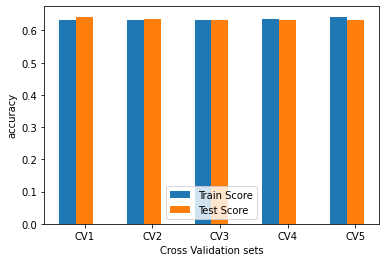

In [80]:
# set width of bar
barWidth = 0.25

 
# Set position of bar on X axis
r1 = np.arange(len(train_scores))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, train_scores, width=barWidth, label='Train Score')
plt.bar(r2, test_scores, width=barWidth, label='Test Score')
 
# Add xticks on the middle of the group bars
plt.ylabel('accuracy')
plt.xlabel('Cross Validation sets')
plt.xticks([r + barWidth for r in range(len(train_scores))], ['CV1', 'CV2', 'CV3', 'CV4', 'CV5'])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("MCP_CV_Score.pdf")
plt.show()


In [81]:
mcp = MultiClassPerceptron(lr=0.075, max_iter=1001)

In [82]:
train_scores2, val_scores2 = mcp.fit_val(x_train, y_train, x_val, y_val)

Iteration: 0	 / Loss: 16.842	 / Train Score: 0.085 / Val Score: 0.085
Iteration: 25	 / Loss: 6.177	 / Train Score: 0.222 / Val Score: 0.221
Iteration: 50	 / Loss: 4.575	 / Train Score: 0.321 / Val Score: 0.322
Iteration: 75	 / Loss: 3.812	 / Train Score: 0.389 / Val Score: 0.386
Iteration: 100	 / Loss: 3.363	 / Train Score: 0.440 / Val Score: 0.437
Iteration: 125	 / Loss: 3.067	 / Train Score: 0.477 / Val Score: 0.477
Iteration: 150	 / Loss: 2.856	 / Train Score: 0.506 / Val Score: 0.507
Iteration: 175	 / Loss: 2.695	 / Train Score: 0.527 / Val Score: 0.530
Iteration: 200	 / Loss: 2.565	 / Train Score: 0.544 / Val Score: 0.546
Iteration: 225	 / Loss: 2.456	 / Train Score: 0.557 / Val Score: 0.559
Iteration: 250	 / Loss: 2.363	 / Train Score: 0.570 / Val Score: 0.572
Iteration: 275	 / Loss: 2.281	 / Train Score: 0.582 / Val Score: 0.582
Iteration: 300	 / Loss: 2.209	 / Train Score: 0.591 / Val Score: 0.592
Iteration: 325	 / Loss: 2.144	 / Train Score: 0.600 / Val Score: 0.599
Iteration:

In [83]:
mcp.score(Xtest, Ytest)

0.6891

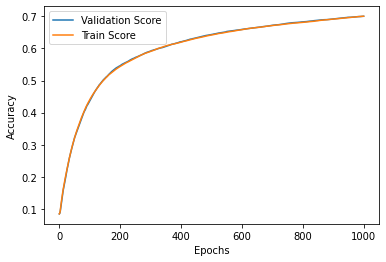

In [84]:
iterations = np.arange(0, len(val_scores2))
plt.plot(iterations, val_scores2,  label='Validation Score')    
plt.plot(iterations, train_scores2, label='Train Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig("MCP_train_val_Score.pdf")
plt.show()

# References
[1] Mantovani, R., Horváth, T., et al, 'An empirical study on hyperparameter tuning of decision trees'
